In [1]:
import numpy as np
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import time
import fb_utils as fb

In [2]:
# load parameters

spec = fb.HYPERPARAMS["ART"]

In [4]:
# create a random filterbank and its tightened version

w_ran = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=False, to_torch=False)
w_tight = fb.fir_tightener3000(w_ran)
# np.save('values/Parseval_w_init.npy', w_init)
# np.save('values/Parseval_w_tight.npy', w_tight)

In [4]:
# data generator

synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [5]:
# conv1D layer with circulant boundary conditions

class TDFilterbank(torch.nn.Module):
    def __init__(self, spec, w):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=1,
            padding=0,
            bias=False)
        
        # initialize the filters to be w_init
        self.psi.weight.data = w[:, :spec["T"]].unsqueeze(1).float()
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = self.psi(x)
        Ux = torch.abs(Wx)
        return Ux
    
baseline = TDFilterbank(spec, w_init)
print(baseline)

TDFilterbank(
  (psi): Conv1d(1, 40, kernel_size=(1024,), stride=(1,), bias=False)
)


In [6]:
# loss functions with penalization terms

# penalizing large kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, inputs, targets, w, beta_k):
        w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        Lam_max = torch.max(w_hat,dim=0).values
        Lam_min = torch.min(w_hat,dim=0).values
        loss = torch.mean(self.loss(inputs, targets)) + beta_k*Lam_max/Lam_min
        return loss
    
# penalizing large ||S - I||^2
    
class SLoss(nn.Module):
   def __init__(self):
       super(SLoss, self).__init__()

   def forward(self, inputs, targets, w, beta_S):
       w = torch.cat((w,torch.zeros([spec["J"], spec["N"]-spec["T"]])),dim=1)
       W = fb.circulant(w)
       S = torch.matmul(W.T,W)
       I = torch.eye(S.shape[0])
       loss = torch.mean(torch.abs(inputs - targets)**2) + beta_S*torch.norm(S-I)**2
       return loss

In [7]:
# training function

def train(baseline, penalization, lr, beta_k, beta_S, n_epochs, epoch_size):
    optimizer = torch.optim.SGD(baseline.parameters(), lr=lr)
    mse = torch.nn.MSELoss()
    if penalization == 'mse':
        criterion = torch.nn.MSELoss() 
    if penalization == 'kappa':
        criterion = KappaLoss() 
    if penalization == 'S':
        criterion = SLoss() 
    losses = []
    conditions = []

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = fb.filterbank_response(inputs, w_tight, mag=True)
        w = baseline.psi.weight[:,0,:]
        loss = mse(outputs, targets)
        running_loss += loss.item()
    print(1000 * running_loss)
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response(inputs, w_tight, mag=True)
            if penalization == 'mse':
                loss = mse(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            if penalization == 'kappa':
                w = baseline.psi.weight[:,0,:]
                loss = criterion(outputs, targets, w, beta_k)
                loss.backward()
                optimizer.step()
                loss2 = mse(outputs, targets)
                running_loss += loss2.item()
            if penalization == 'S':
                # use this loss only every 10th iteration
                if np.mod(i+1,100) == 0:
                    w = baseline.psi.weight[:,0,:]
                    loss = criterion(outputs, targets, w, beta_S)
                    loss.backward()
                    optimizer.step()
                else:
                    loss = mse(outputs, targets)
                    loss.backward()
                    optimizer.step()                
                    loss2 = mse(outputs, targets)
                    running_loss += loss2.item()
        losses.append(running_loss)
        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.concatenate((w,np.zeros([spec["J"], spec["N"]-spec["T"]])),axis=1)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)
        print(1000 * running_loss)

    return losses, conditions

In [8]:
# training hyperparameters

n_epochs = 50
epoch_size = 100
lr = 0.1
beta_k = 0.0001
beta_S = 0.00005

In [9]:
# train: no penalization

start = time.time()

baseline_no = TDFilterbank(spec, w_init)
losses_no, conditions_no = train(
    baseline=baseline_no,
    penalization='mse',
    lr=lr,
    beta_k=beta_k,
    beta_S=beta_S,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

end = time.time()
time_no = end - start

np.save('values/Parseval_losses_no.npy',losses_no)
np.save('values/Parseval_conditions_no.npy',conditions_no)

7.1909851794771384


100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


4.1670447226351826


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


2.2993908028183796


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


1.6708241982996697


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


1.3717875717702555


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


0.9507633394605364


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


0.8136874664614879


100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


0.6268994103493242


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


0.5292084408665687


100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


0.45918904231712077


100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


0.382089212507708


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


0.3000724985611214


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


0.23805741483329257


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


0.21416856955625008


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


0.16992643891455828


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


0.1673533801351823


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


0.12725238843813713


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


0.10812806736737457


100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


0.09662854328240655


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


0.08515286947385903


100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


0.08510692365248929


100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


0.05961207348015307


100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


0.04930918148104979


100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


0.0441915568849538


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


0.03861493830115137


100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


0.03345316564384859


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


0.031013972876081652


100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


0.029284200090629042


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


0.019771633495757612


 45%|████▌     | 45/100 [00:16<00:45,  1.22it/s]

In [ ]:
# train: kappa penalization

start = time.time()

baseline_kappa = TDFilterbank(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline_kappa,
    penalization='kappa',
    lr=lr,
    beta_k=beta_k,
    beta_S=beta_S,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

end = time.time()
time_kappa = end - start

np.save('values/Parseval_losses_kappa.npy',losses_kappa)
np.save('values/Parseval_conditions_kappa.npy',conditions_kappa)

8.832018771499861


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


3.6886765010422096


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


1.3274772782096989


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


0.5989203593799175


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


0.29972560025726125


100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


0.13118028971348394


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


0.04620162488322421


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


0.012129322254139652


100%|██████████| 100/100 [00:20<00:00,  4.76it/s]


0.005836062355157878


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


0.00395421278476249


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


0.0027447096995203424


100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


0.002197195011710562


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


0.001572779508407507


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


0.0012170502916575288


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


0.0008995990039561974


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


0.0008253670762403686


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


0.0005749033420432426


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


0.00045715343499619365


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


0.0004238355144625672


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


0.0003096603836127976


100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


0.0003692691426249173


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


0.00016878378372719993


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


0.0001690887117544726


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


0.0002547790312612541


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


0.00012871778432010927


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


0.00014697072422964474


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


0.0001781305500464514


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


0.00017736345756316774


100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


9.034875589862545e-05


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


0.00014233429819487942


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


0.00013120777502938913


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


0.00011140435806147875


100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


0.00021422365481917408


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


0.0013722671103888473


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


0.0016191312049995688


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


0.0018135145706255074


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


0.0018952549687978326


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


0.001577873172287081


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


0.001594773445634523


100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


0.0017857927088749115


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


0.001929609326906112


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


0.0016840640333359858


100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


0.001748333232076682


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


0.001723857915303384


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


0.001707902217207291


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


0.001903217287435588


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


0.0015592219286819642


100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


0.0017407381835421454


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


0.001977974277811434


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


0.001642918120658976


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]

0.0017925383386518945


In [ ]:
# train: S penalization

start = time.time()

baseline_S = TDFilterbank(spec, w_init)
losses_S, conditions_S = train(
    baseline=baseline_S,
    penalization='S',
    lr=lr,
    beta_k=beta_k,
    beta_S=beta_S,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

end = time.time()
time_S = end - start

np.save('values/Parseval_losses_S.npy',losses_S)
np.save('values/Parseval_conditions_S.npy',conditions_S)

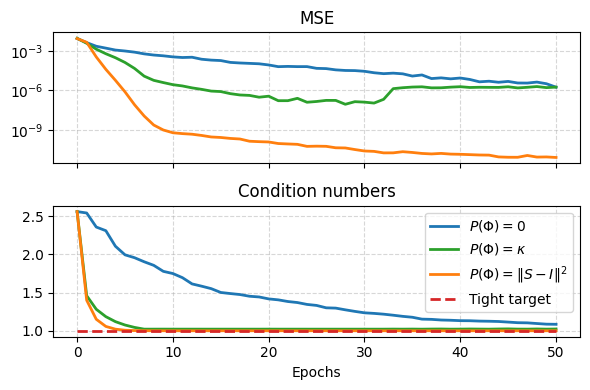

In [ ]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_no, 'tab:blue', linewidth=2)
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, losses_S, 'tab:orange', linewidth=2)
# semilogy
ax.set_yscale('log')

ax.set_title('MSE')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_no, 'tab:blue', linewidth=2, label='$P(\Phi) = 0$')
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2, label='$P(\Phi) = \kappa$')
ax.plot(Ts, conditions_S, 'tab:orange', linewidth=2, label = '$P(\Phi) = \Vert S-I \Vert^2$')
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, linestyle='--', label = 'Tight target')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper right')

plt.tight_layout()

plt.savefig('Reproducing_Random_Tightness.pdf', bbox_inches='tight')

In [ ]:
print('No penalization', time_no/60/n_epochs, 'sec/epoch')
print('Kappa penalization', time_kappa/60/n_epochs, 'sec/epoch')
print('S penalization', time_S/60/n_epochs, 'sec/epoch')
print('Kappa penal. is', time_S/time_kappa, 'times faster than S penal')
print('Kappa penal. is', time_kappa/time_no, 'times slower than no penal.')

$P(\Phi) = 0: $ 0.3453894000053406 sec/epoch
$P(\Phi) = \kappa: $ 0.35364655407269796 sec/epoch
$P(\Phi) = \Vert S-I \Vert^2:$ 0.4396249686876933 sec/epoch
Ours is 1.2431196165347649 times faster than using S and  1.0239067964078508 times slower than using no regularizer.
